# 23 - 处理效应异质性和非线性的挑战

由于缺乏真实的反事实，预测单个单位的处理效应极其困难。因为我们只能观察到一个潜在结果 $T(t)$，无法直接估计个体处理效应。相反，我们只能依靠目标变换（也可视为巧妙设计的损失函数）来在期望意义下估计条件处理效应。然而，这并不是唯一的挑战。由于处理效应本身非常难以捉摸，其估计量通常非常嘈杂。这对需要根据处理效应对个体进行分段的应用有很大的现实影响，比如我们希望进行个性化处理分配时。

我们接下来会看到，在某些情况下，如果我们不直接去估计 CATE，而是关注另一个方差更小的代理目标，我们可以获得更好的处理效应分段。这种情况常见于结局变量 $Y$ 为二元变量时。

## 二元结局上的处理效应


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")


In [4]:
from typing import List

import numpy as np
import pandas as pd
from toolz import curry, partial

@curry
def avg_treatment_effect(df, treatment, outcome):
    return df.loc[df[treatment] == 1][outcome].mean() - df.loc[df[treatment] == 0][outcome].mean()
    
    

@curry
def cumulative_effect_curve(df: pd.DataFrame,
                            treatment: str,
                            outcome: str,
                            prediction: str,
                            min_rows: int = 30,
                            steps: int = 100,
                            effect_fn = avg_treatment_effect) -> np.ndarray:
    
    size = df.shape[0]
    ordered_df = df.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_rows, size, size // steps)) + [size]
    return np.array([effect_fn(ordered_df.head(rows), treatment, outcome) for rows in n_rows])


@curry
def cumulative_gain_curve(df: pd.DataFrame,
                          treatment: str,
                          outcome: str,
                          prediction: str,
                          min_rows: int = 30,
                          steps: int = 100,
                          effect_fn = avg_treatment_effect) -> np.ndarray:
    

    size = df.shape[0]
    n_rows = list(range(min_rows, size, size // steps)) + [size]

    cum_effect = cumulative_effect_curve(df=df, treatment=treatment, outcome=outcome, prediction=prediction,
                                         min_rows=min_rows, steps=steps, effect_fn=effect_fn)

    return np.array([effect * (rows / size) for rows, effect in zip(n_rows, cum_effect)])


这里有一个你在科技公司工作时极有可能遇到的常见问题：管理层希望通过某种“助推”来提高客户对产品的转化率。例如，他们可能通过向客户提供 10 巴西雷亚尔的代金券来促进应用安装后的内购，或在客户第一次使用叫车应用时提供一次免费乘车，或者在投资平台的前 3 个月降低交易费用。由于助推通常成本较高，他们不愿意对每个人都这样做。更理想的是，我们能把助推仅用于那些对其最敏感的客户。

用因果推断的术语来说，这类业务问题属于“处理效应异质性”（TEH）范畴。具体地，你有一个昂贵的助推作为处理 $T$，转化率作为二元结局 $Y$，以及客户特定的处理前特征 $X$。你可以像使用 Double/Debiased ML 那样估计条件平均处理效应 $E[Y_1 - Y_0 \mid X]$（如果处理是连续的，则是 $E[Y'(T)\mid X]$），最终只对估计的处理效应最高的客户实施助推。用业务术语说，你就是在个性化你的转化策略，找到那些转化增量高的客户群体，并只在他们身上使用助推。

然而，这里有一个使 TEH 方法不那么显而易见的复杂因素——结局是二元的。这大大增加了难度。因为这一点有些违反直觉，所以我先展示会发生什么，再解释其原因。

## 模拟一些数据

让我们保持简单，但仍然贴近实际。我们将模拟完全随机的处理 `nudge`，它服从参数 $p=0.5$ 的伯努利分布。这意味着助推的分配就像抛硬币一样，而且不存在需要关注的混杂因素。

$ nudge \sim \mathcal{B}(0.5) $

接下来，我们模拟客户的协变量 `age` 和 `income`，它们分别服从伽马分布。这些是你对客户已知的信息，因此你希望根据这些变量进行个性化。换言之，你希望根据年龄和收入将客户分组，使得其中一组对 `nudge` 处理高度响应。

$ age \sim G(10, 4) $

$ income \sim G(20, 2) $

最后，我们模拟转化率。为此，我们首先**构建一个服从线性模型的潜在变量**并加入随机噪声。重要的是要注意，`income` 对 $Y_{latent}$ 有很高的预测力，但**它并不改变处理效应**。简单来说，助推对所有收入水平的 $Y_{latent}$ 的影响是相同的。相反，`age` 只通过与 `nudge` 的交互影响 $Y_{latent}$。

$Y_{latent} \sim N(-4.5 + 0.001 \ income + nudge + 0.01 \ nudge \ age, 1)$

一旦我们有了 $Y_{latent}$，我们通过设置 $Y_{latent} > x$ 来模拟 `conversion`。首先令 `x=0`，这样转化率大约是 50%。即平均有 50% 的客户会选择我们的产品。

$conversion = 1\{Y_{latent} > 0\}$


In [8]:
np.random.seed(123)

n = 100000
nudge = np.random.binomial(1, 0.5, n)
age = np.random.gamma(10, 4, n)
estimated_income = np.random.gamma(20, 2, n)*100

latent_outcome = np.random.normal(-4.5 + estimated_income*0.001 + nudge + nudge*age*0.01)
conversion = (latent_outcome > .1).astype(int)

我们还将所有数据存入一个 DataFrame 以便处理。同时检查一下平均转化率确实接近 50%。

In [11]:
df = pd.DataFrame(dict(conversion=conversion,
                       nudge=nudge,
                       age=age,
                       estimated_income=estimated_income,
                       latent_outcome=latent_outcome))

df.mean()

conversion             0.518260
nudge                  0.500940
age                   40.013487
estimated_income    3995.489527
latent_outcome         0.197076
dtype: float64

至于平均处理效应，由于处理是随机的，我们可以将其估计为处理组和对照组的平均值差：$E[Y\mid T=1] - E[Y\mid T=0]$。让我们看看这些处理组平均值是什么样的。我们将同时考察潜在结果和实际转化两个角度。有一些重要的现象值得注意。

In [14]:
df.groupby("nudge")[["latent_outcome", "conversion"]].mean()

,latent_outcome,conversion
nudge,,
0,-0.505400,0.320503
1,0.896916,0.715275


In [16]:
avg_treatment_effect(df, "nudge", "latent_outcome")

1.4023163965477659

In [18]:
avg_treatment_effect(df, "nudge", "conversion")

0.39477273768476406

对潜在结果而言，ATE 很容易计算。根据我们的数据生成模型，该效应应为 `1 + avg(age)*0.01`。由于平均年龄约为 40，这给我们一个大约为 1.4 的平均处理效应。事情在转化率的 ATE 上变得更有趣（也更复杂）。**由于转化率被限制在 0 到 1 之间，其 ATE 将不是线性的**。因此，我们不能像对潜在结果那样通过简单的公式推断它（虽然有公式，但非常复杂）。我们姑且认为该效应较小。这是有道理的，对吧？处理不可能将转化率提高 1.4 个百分点，因为转化率不能超过 100%。我希望你记住这一点，这对理解我们接下来将看到的内容至关重要。

现在来谈谈条件平均处理效应 (CATE)。观察我们的数据生成过程，我们知道 `estimated_income` 可以预测转化率，但并不改变助推对转化的影响。因此，基于 `estimated_income` 对客户进行分段将产生具有相同处理效应的组。相反，`age` 只通过与助推的交互影响转化。不同的年龄分段对处理的反应会非常不同，而不同的收入分段不会。换句话说，`estimated_income` 不是一个好的个性化变量，而 `age` 是。

一个认识这一点的方法是通过累积效应曲线。`age` 的曲线应该从远离 ATE 的地方开始，并缓慢趋近于它，而 `estimated_income` 的曲线应该只是围绕 ATE 上下波动。对助推作用在潜在结果上的累积效应曲线，正是我们看到的这种情形。


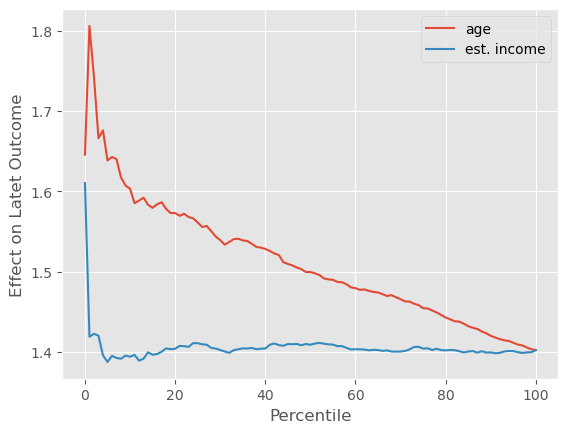

In [21]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "latent_outcome", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()
plt.xlabel("Percentile")
plt.ylabel("Effect on Latet Outcome");

再次强调，潜在结果的情况非常理想。由于其线性特性，我们的预期与现实非常吻合。但在现实生活中，我们既不关心也无法观测潜在结果。我们拥有的只有转化率。而对于转化率来说，情形要复杂得多。如果我们绘制累积效应曲线，`age` 仍然展示出一些处理效应异质性：曲线从高于 ATE 的位置开始，并缓慢收敛到 ATE。这意味着年龄越大，处理效应越高。目前为止，一切如我们所预期。


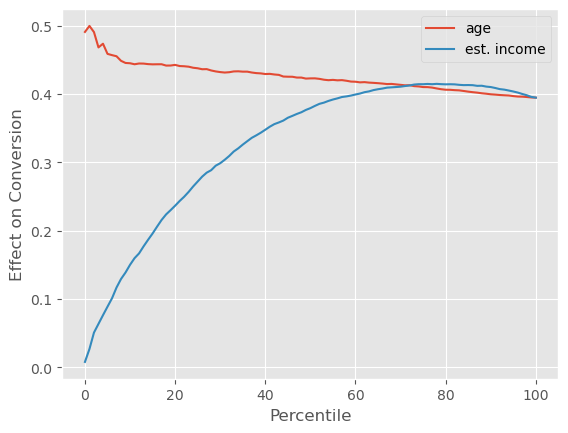

In [24]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.legend()
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversion");

然而，`estimated_income` 展现出了非常大的处理效应异质性。收入较高的客户具有更低的处理效应，这使得累积效应曲线从零开始，然后超过 ATE，最后才收敛到 ATE。这告诉我们，就个性化而言，按 `estimated_income` 分组所产生的处理效应异质性比按 `age` 分组更大。

这是不是很令人困惑？为什么我们明知 `age` 会驱动效应异质性，却发现在个性化上，按 `age` 分组竟然不如按 `estimated_income` 分组有效？答案在于**结局函数的非线性**。虽然 `estimated_income` 不改变助推对潜在结果的影响，但在将潜在结果转换为转化率时（至少间接地）它会改变处理效应。转化率不是线性的，这意味着**它的导数取决于你所在的位置**。由于转化率上界为 1，如果已经很高，再想提升就很难。换句话说，高转化率区间的导数非常小。低端同样如此：由于转化率有下界 0，如果已经很低，其导数也很小。转化率呈 S 形曲线，在两端导数都很低，我们可以通过绘制按 `estimated_income` 分箱（箱宽 100）的平均转化率来看出这一点。


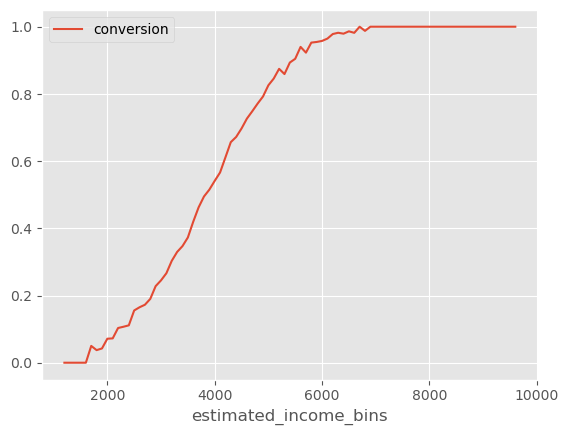

In [27]:
(df
 .assign(estimated_income_bins=(df["estimated_income"]/100).astype(int)*100)
 .groupby("estimated_income_bins")
 [["conversion"]]
 .mean()
 .plot()
);

注意，当转化率很高时，这条曲线的斜率（导数）非常小。当转化率很低时，斜率也很小（虽然由于这一区域样本较少，这一点不易观察）。有了这条信息，我们可以解释为什么 `estimated_income` 会产生高的处理效应异质性。

由于 `estimated_income` 对转化率的预测力很强，我们可以说不同 `estimated_income` 的客户位于 S 形转化曲线的不同位置。`estimated_income` 非常高或非常低的客户落在曲线的两端，在那里导数较小，这意味着提高转化率更加困难，也意味着处理效应可能较小。另一方面，中等收入范围的客户位于转化曲线的中间地带，在那里导数较大，因此处理效应可能也较大。我说“可能”是因为，理论上，一个变量可能有如此强的效应修改力量，以至于它主导了我们沿着转换曲线看到的导数变化。然而，至少从我的经验来看，S 形转化曲率往往主导其他任何效应修改。

当然，这不仅是我的观点。下面这张图来自 Susan Athey 在哥伦比亚数据科学研究院的演讲幻灯片。她在讨论通过助推让学生申请联邦助学金以支付大学费用的效果。这也是一个转化问题。她发现最佳策略是针对那些已经有较高转换可能性的学生。她还表示，针对那些转换概率低的学生通常不是好主意。

![img](./images/23/slide-susan-athey.png)

等等！这与你上面说的矛盾！你不是说在曲线的低端和高端，处理效应都很小吗？

没错。然而在现实中，转化率很少覆盖整个 S 形曲线。通常所有人都挤在曲线的一端。在商业实践中，你的平均转化率很少是 50%，更常见的是 70% 到 90%，或者 1% 到 20% 这样的水平。在这些更常见的情形下，针对高基线概率人群可能是好主意，也可能不是。

我的意思是：我们沿用之前的潜在结果，但现在生成一个平均转化率较低的情形，将转化率设定为 `latent_outcome > 2`；接着，再构造一个平均转化率较高的情形，将转化率设定为 `latent_outcome > -2`。


In [30]:
df["conversion_low"] = conversion = (latent_outcome > 2).astype(int)
df["conversion_high"] = conversion = (latent_outcome > -2).astype(int)

print("Avg. Low Conversion: ", df["conversion_low"].mean())
print("Avg. High Conversion: ", df["conversion_high"].mean())

Avg. Low Conversion:  0.12119
Avg. High Conversion:  0.9275


根据我们对转化率非线性的理解，我们已经可以预测接下来会发生什么。在低转化率的情况下，针对那些具有高基准转化率（高 `estimated_income`）的群体将更为有效。这是因为我们处于S形转化曲线的左侧，在这个区域，基准转化率越低，导数会越小。在这个区域，**高基准转化率将转化为更高的处理效应**。因此，我们应该对高基准转化率的群体进行干预，而这些群体的特征就是拥有更高的 `estimated_income`。

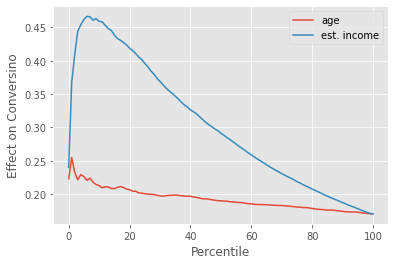

In [13]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_low", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversion");
plt.legend();

正如我们所预测的，具有高 `estimated_income`（即高基准转化率）的群体，确实表现出了更高的处理效应。

现在，对于转化率较高的另一种情况，平均而言，**高基准转化率的群体会有较低的处理效应**。因此，针对那些具有高 `estimated_income` 的群体并不是一个好主意。我们可以通过倒置的累计效应曲线看到这一点，曲线显示了高 `estimated_income` 群体的处理效应较低。

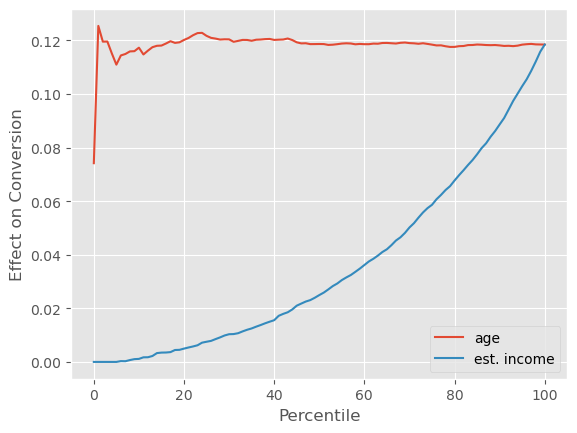

In [35]:
cumulative_effect_fn = cumulative_effect_curve(df, "nudge", "conversion_high", min_rows=500)

age_cumm_effect_latent = cumulative_effect_fn(prediction="age")
inc_cumm_effect_latent = cumulative_effect_fn(prediction="estimated_income")

plt.plot(age_cumm_effect_latent, label="age")
plt.plot(inc_cumm_effect_latent, label="est. income")
plt.xlabel("Percentile")
plt.ylabel("Effect on Conversion")
plt.legend();

总结一下，我们看到当结局是二元变量时，处理效应往往受到 S 形函数曲率（导数）的支配。

![img](./images/23/logistic.png)

例如，在我们的转化问题中，如果**平均转化率较低**，我们位于逻辑曲线的左侧，**处理效应会在高基线转化率时更大**。这意味着助推策略应该优先针对那些已有较高转化概率的客户。另一方面，如果**平均转化率较高**，我们位于逻辑曲线的右侧，此时导数（因此处理效应）会**在较低基线转化率的客户身上更大**。

这确实有点复杂，但可以简化为：**就去处理那些基线转化率接近 50% 的人**。数学上的依据很可靠：逻辑函数的导数在 50% 时达到峰值，所以只需针对那些接近这一点的单位。

更妙的是，这是为数不多的经验法则与数学一致的情况。在营销领域，转化问题非常常见，人们普遍认为不应该将资源浪费在“必输无疑”的客户（转化概率非常低）或“稳操胜券”的客户（转化概率非常高）身上，而应集中于中间地带。这很有意思，因为这与我们通过更正式的因果推理得出的结论完全一致。


# 连续处理与非线性

我们详细探讨了一个二元结局使处理效应异质性分析更加困难的例子。但这种现象远不止营销中的转化问题。例如，在 2021 年，全球首次向公众大规模提供获批的 COVID‑19 疫苗。当时，一个关键问题是谁应该优先接种疫苗。这显然也是一个处理效应异质性问题。决策者希望首先给那些受益最大的人接种。在这种情况下，处理效应是预防死亡或住院。那么，接种后谁的死亡或住院风险下降最多？在大多数国家，是老年人和有基础疾病（共病）的群体。这些人**感染 COVID‑19 时死亡的可能性更高**。另外，COVID 的死亡率（谢天谢地！）远低于 50%，这使得我们处于逻辑函数的左侧。在这一区域，按照我们在营销案例中所用的同一理由，优先接种那些基线死亡概率高的人是有道理的，这正是上述群体。是否只是巧合？也许吧。请记住我不是卫生专家，所以可能理解有误，但这个逻辑对我来说很有道理。

在营销助推和 COVID‑19 疫苗这两个例子中，**导致处理效应异质性复杂化的关键因素是结局函数 $Y(0)$ 的非线性**。这种非线性意味着当我们从 $Y(0)$ 转移到 $Y(1)$ 时，结局的增加主要是由于结局函数的曲率。我们看到在二元结局中 $E[Y\mid X]$ 遵循逻辑曲线，这种非线性造成了问题。但这种现象更具普遍性。事实上，它在商业中反复出现，尤其是当处理是连续变量时。为了更清楚地说明这一点，让我们再看最后一个例子。

考虑一个经典的定价问题。你为一家流媒体公司如 Netflix 或 HBO 工作。公司想知道对客户应收取什么价格。为回答这一问题，他们设计了一项实验，随机将客户分配到不同价格的套餐：5 巴西雷亚尔/月、10 巴西雷亚尔/月、15 巴西雷亚尔/月或 20 巴西雷亚尔/月。这样做不仅希望了解客户对价格上涨的敏感性，还希望了解不同类型的客户是否有不同的敏感程度。下图显示了该实验按两个客户群的结果：`A` 是收入估计较高的客户，`B` 是收入估计较低的客户。


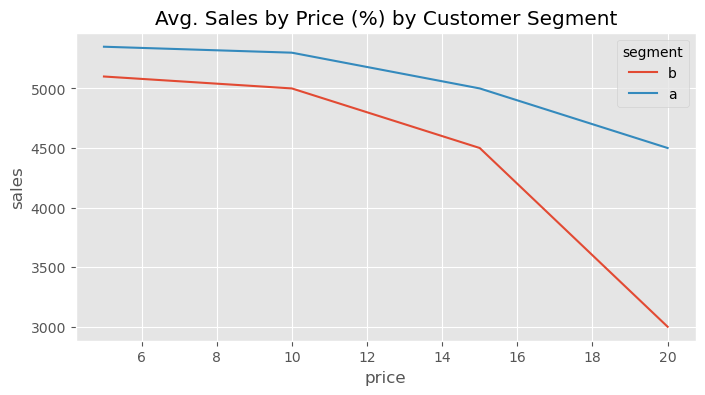

In [39]:
data = pd.DataFrame(dict(
    segment= ["b", "b", "b", "b",  "a", "a", "a", "a",],
    price=[5, 10, 15, 20, ] * 2,
    sales=[5100, 5000, 4500, 3000,  5350, 5300, 5000, 4500]
))

plt.figure(figsize=(8,4))
sns.lineplot(data=data, x="price", y="sales", hue="segment")
plt.title("Avg. Sales by Price (%) by Customer Segment");

有了这份数据，公司希望回答如下问题：谁对折扣更敏感？换句话说，我们如何**根据价格敏感度（销售对价格的弹性）对客户进行排序**？观察曲线，我们感觉 `A` 组整体上对折扣不那么敏感，尽管它产生的收入更高。不过，我们也注意到曲线存在一定的弯曲。如果考虑这种曲率，处理效应的排序不仅仅是 `A` 与 `B` 之间的比较。处理效应还取决于他们在处理曲线上的位置。例如，对于 `A` 组客户，从 15 巴西雷亚尔降到 10 巴西雷亚尔的处理效应要高于 `B` 组客户从 5 巴西雷亚尔升至 10 巴西雷亚尔的处理效应：

$$
E[Y(10) - Y(5) \mid Seg=B] < E[Y(15) - Y(10) \mid Seg=A]
$$

如果我们对这些处理效应进行排序，结果大概如下：


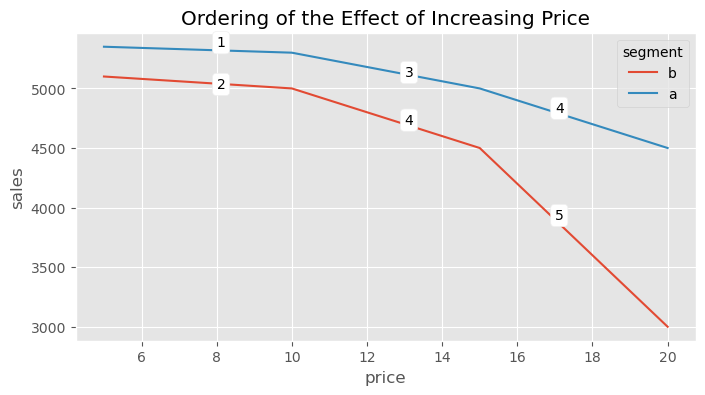

In [42]:
plt.figure(figsize=(8,4))
sns.lineplot(data=data, x="price", y="sales", hue="segment")

plt.annotate("1", (8, 5350), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("2", (8, 5000), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("3", (13, 5100), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("4", (13, 4700), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("4", (17, 4800), bbox=dict(boxstyle="round", fc="1"))
plt.annotate("5", (17, 3900), bbox=dict(boxstyle="round", fc="1"))

plt.title("Ordering of the Effect of Increasing Price");

正如结局为二元变量时的情形一样，在这个例子中，**处理效应与结果相关**。销售越高（价格越低），绝对处理效应越小；销售越低（价格越高），绝对处理效应越小。但在这里，情况更复杂，因为**效应不仅与结果相关，还与处理水平相关**。这使得回答反事实问题更加棘手。例如，假设你的实验数据实际长成了下面的样子：对于 `A` 组（富裕人群），你测试了较高的价格，而对于 `B` 组，你只测试了较低的价格。这种情况非常常见，因为公司通常只想在他们认为合理的处理范围内进行实验。


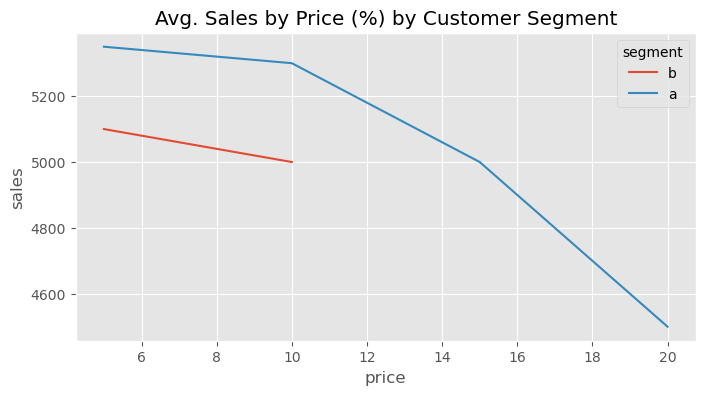

In [45]:
data = pd.DataFrame(dict(
    segment= ["b", "b", "b", "b",  "a", "a", "a", "a",],
    price=[5, 10, 15, 20, ] * 2,
    sales=[5100, 5000, 4500, 3000,  5350, 5300, 5000, 4500]
))

plt.figure(figsize=(8,4))
sns.lineplot(data=data.loc[lambda d: (d["segment"] == "a") | (d["price"] < 12) ], x="price", y="sales", hue="segment")
plt.title("Avg. Sales by Price (%) by Customer Segment");

如果你天真地将处理效应结果简单汇总，可能会得出 `A` 组对提价的价格弹性远高于 `B` 组的结论。但那只是因为对于 `B` 组，你只探索了低处理效应区域。

那么，当处理效应随着处理水平和结果水平而变化时，你可以做什么？说实话，这仍是一个活跃的研究领域。在实践中，你能做的最好的事情是在回答“哪类客户对处理更敏感”时**非常谨慎**。确保比较的客户类型有相同的处理分布。如果没有，就要对外推处理效应持高度怀疑态度。例如，在上面的例子中，尽管 `B` 组客户对提价似乎不那么敏感，但如果你对该组客户实行高于 10 巴西雷亚尔的价格，你并不知道这一结论是否仍然成立。

你还可以尝试做的一件事是对反应曲线进行线性化。这里的想法是，通过变换处理或结局（或两者），使它们之间的关系看起来像一条直线。由于直线的导数是恒定的，这可以消除处理效应随曲线位置而变化的问题。例如，如果我们将价格变量取负，对其进行四次方运算然后再反转符号，我们得到的是一种大致线性的关系。在这份变换后的数据中，`A` 对提价的敏感度低于 `B` 的说法更加合理，因为它不再取决于我们处于曲线的哪一部分。


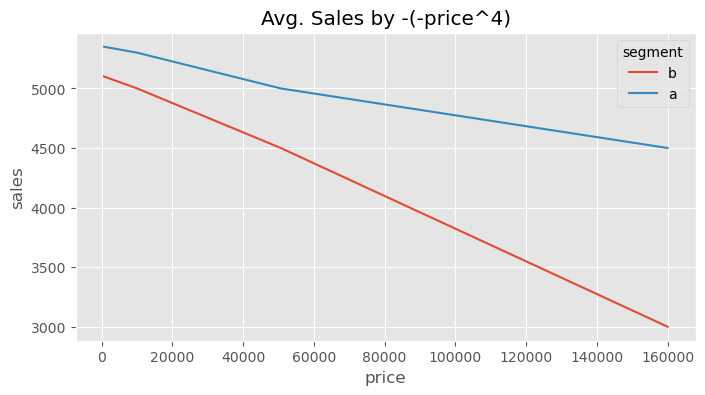

In [48]:

plt.figure(figsize=(8,4))
sns.lineplot(data=data.assign(price = lambda d: -1*(-d["price"]**4)),
             x="price", y="sales", hue="segment")
plt.title("Avg. Sales by -(-price^4)");

然而，这种做法有很多缺点。首先，并非总能线性化一条曲线。在我们的例子中，你可以清楚地看到这种线性化并不完美。但更重要的是，有时放弃曲率在业务上毫无意义。在我们的定价例子中，完全有可能我们认为以 15 巴西雷亚尔的价格对 `A` 组客户提价比对 5 巴西雷亚尔的 `B` 组客户提价更为敏感。这会导致一个合理的决策，即将 `A` 组客户的价格从 15 调整到 10，但不对 `B` 组的价格做任何改变。


## 关键观点

我意识到我提出的问题可能比提供的答案还多。不过，有时对一个问题最好的做法就是充分意识到它的存在。在本章中，我希望我能让你意识到，当我们关心的结局是非线性时会出现的各种复杂性。

对于二元结局，这是一个常见且研究较多的问题。在这种情况下，处理效应在平均结局接近 0.5 时往往较高。由于结局被限制在 0 和 1 之间，如果我们太接近 0 或 1，效应往往非常小。

当非线性出现在连续结局中时，情况就更为复杂了。在这种情况下，你能做的最好事情就是非常仔细地思考问题。试着回答，你究竟更关心不受基线影响的处理效应，还是基线本身也很重要。仅仅这个问题就能为你提供宝贵的指导原则。

## 参考说明

这里写的大部分内容都来自作者对这个问题的个人经验。不过，作者确实找到了一篇涉及这个主题的学术文章：《Causal Classification: Treatment Effect Estimation vs. Outcome Prediction》由 Fernández‑Loría 和 Provost 撰写，其中讨论了处理效应与结果变量相关的情况。

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立助理教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。